In [1]:
import numpy as np
from numpy.random import default_rng

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
import sys

import bayesloop as bl
import sympy
from scipy.stats import gamma, beta, expon

sys.path.append("../../src")
from transformations import *
from networks_10092022 import *

from tqdm.notebook import tqdm
from functools import partial

c:\Users\Lukas.Schumacher\miniconda3\envs\cogModeling\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
data = np.array([5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4,
                 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0,
                 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
                 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 3, 0,
                 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

N_OBS = len(data)

In [2]:
MACRO_MEAN = beta.mean(1, 25)
MACRO_STD = beta.std(1, 25)
MICRO_MEAN = expon.mean(scale=2)
MICRO_STD = expon.std(scale=2)

In [3]:
# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

## Bayesloop

In [ ]:
S = bl.HyperStudy()
S.load(data, timestamps=np.arange(1852, 1962))

In [ ]:
grid_length = 4000

In [ ]:
# low level model
L = bl.observationModels.Poisson('accident_rate', bl.oint(0, 15, grid_length), prior=sympy.stats.Exponential('expon', 0.5))
# L = bl.observationModels.Poisson('accident_rate', bl.oint(0, 6, 1000))
S.set(L)

In [ ]:
# high level model
T = bl.transitionModels.GaussianRandomWalk('sigma', bl.oint(0, 2, grid_length), target='accident_rate', prior=sympy.stats.Beta("beta", 1, 25))
S.set(T)

In [ ]:
# fit model to data
S.fit(forwardOnly=True)

In [ ]:
# get micro posterior densities
time = np.arange(1852, 1962)
n_obs = time.shape[0]

post_densities = np.zeros((n_obs, grid_length))
for t in range(n_obs):
    post_densities[t] = S.getParameterDistribution(time[t], "accident_rate")[1]

post_means = S.getParameterMeanValues("accident_rate")
post_grid = S.getParameterDistribution(1852, "accident_rate")[0]

In [ ]:
# calculate posterior stds
bl_post_std = np.zeros(n_obs)
for i in range(n_obs):
    center_grid = (post_grid - post_means[i])**2
    bl_post_std[i] = np.sqrt(np.sum(post_densities[i] * center_grid) / np.sum(post_densities[i]))

## BayesFlow

In [ ]:
def micro_prior_fun(batch_size, scale=1):
    return default_rng().exponential(scale, size=(batch_size, 1)).astype(np.float32)

def macro_prior_fun(batch_size, alpha=1., beta=25.):
    return default_rng().beta(alpha, beta, size=(batch_size, 1)).astype(np.float32)

In [ ]:
@njit
def random_walk(theta0, sigmas, T, lower_bound=0., upper_bound=8.):
    B = theta0.shape[0]
    D = theta0.shape[1]
    theta_t = np.zeros((B, T, D))
    theta_t[:, 0, :] = theta0
    z = np.random.randn(B, T-1, D)
    for t in range(1, T):
        theta_t[:, t, :] = np.minimum(
            np.maximum(theta_t[:, t-1, :] + sigmas * z[:, t-1, :], lower_bound), upper_bound)
    return theta_t

In [ ]:
def poisson_process(theta_t):
    T = theta_t.shape[0]
    x = np.zeros(T)
    for t in range(T):
        x[t] = np.random.poisson(lam=theta_t[t])
    return np.atleast_2d(x).T

def batch_poisson_process(theta_t, diff_fun=poisson_process):
    B, T = theta_t.shape[0], theta_t.shape[1]
    x = np.zeros((B, T, 1))
    for b in range(B):
        x[b] = diff_fun(theta_t[b])
    return x

In [ ]:
# back transform of np.log1p(x) is np.expm1(x)
def generator_fun(batch_size, T):
    theta0 = micro_prior_fun(batch_size)
    eta = macro_prior_fun(batch_size)
    theta_t =  random_walk(theta0, eta, T)
    x = batch_poisson_process(theta_t)

    # standardize parameters
    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), np.log1p(x).astype(np.float32)

In [ ]:
eta_z, theta_t_z, x = generator_fun(32, 110)
x.shape

In [ ]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [ ]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            macro_params, micro_params, data = generator() 

            # Forward pass
            posterior = network(data)

            # loss computation
            T = int(micro_params.shape[1])
            loss = nll(tf.concat([tf.stack([macro_params] * T, axis=1), micro_params], axis=-1), posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [ ]:
network_settings = {
    'embedding_lstm_units' : 512,
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 1,
    'n_macro_params': 1
}
network = DynamicGaussianNetworkJoint(network_settings)

In [ ]:
T = N_OBS
batch_size = 32
simulator = partial(generator_fun, T=T, batch_size=batch_size)
epochs = 25
steps_per_epoch = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
# losses = []
# for ep in range(1, epochs+1):
#     with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses_ep = epoch_trainer(simulator, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(losses_ep)

In [ ]:
# network.save_weights('trained_networks/poisson_process_joint_20Sept')

## Evaluation

In [ ]:
network.load_weights("../../trained_networks/poisson_process_joint_20Sept")

In [ ]:
log_data = np.atleast_3d(np.log1p(data).astype(np.float32)).T
log_data.shape

In [ ]:
# fit model to data
eta, theta_t = network.sample_n(log_data[:1, :, :1], 4000)

In [ ]:
micro_post = theta_t[:, 0, :, 0]
micro_post = unscale_z(micro_post, MICRO_MEAN, MICRO_STD)

In [ ]:
micro_post_mean = micro_post.numpy().mean(axis=0)
micro_post_std = micro_post.numpy().std(axis=0)

In [ ]:
# np.save("../../saved_arrays/micro_post_mean_joint.npy", micro_post_mean)
# np.save("../../saved_arrays/micro_post_std_joint.npy", micro_post_std)

# np.save("../../saved_arrays/post_means.npy", post_means)
# np.save("../../saved_arrays/bl_post_std.npy", bl_post_std)

# np.save("../../saved_arrays/rawTimestamps.npy", time)
# np.save("../../saved_arrays/rawData.npy", data)

In [4]:
micro_post_mean = np.load("../../saved_arrays/micro_post_mean_joint.npy")
micro_post_std = np.load("../../saved_arrays/micro_post_std_joint.npy")

post_means = np.load("../../saved_arrays/post_means.npy")
bl_post_std = np.load("../../saved_arrays/bl_post_std.npy")

time = np.load("../../saved_arrays/rawTimestamps.npy")
data = np.load("../../saved_arrays/rawData.npy")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


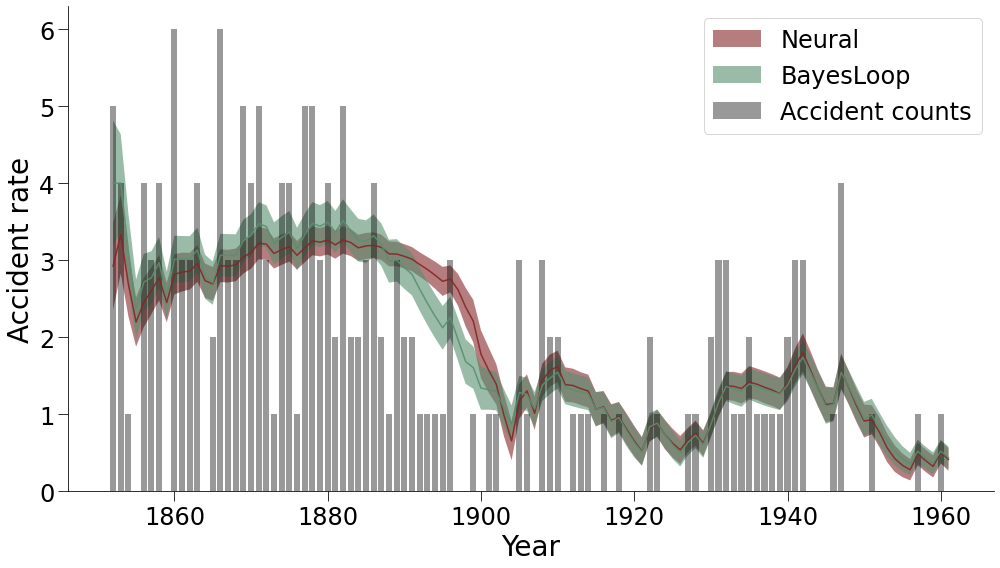

In [5]:
time = np.arange(1852, 1962)
plt.figure(figsize=(14, 8))
plt.plot(time, micro_post_mean, alpha=0.9, color='#852626')
plt.fill_between(time, micro_post_mean+micro_post_std/2, micro_post_mean-micro_post_std/2, alpha=0.6, label='Neural', color='#852626', edgecolor="none")

plt.plot(time, post_means, alpha=0.9, color='#598f70')
plt.fill_between(time, post_means+bl_post_std/2, post_means-bl_post_std/2, alpha=0.6, label='BayesLoop', color='#598f70', edgecolor="none")
# plot of raw data
plt.bar(time, data, align='center', facecolor='black', alpha=.4, label="Accident counts")

plt.ylabel('Accident rate', fontsize=28)
plt.xlabel('Year', fontsize=28)
plt.tick_params(axis='both', which='major', length=10, labelsize=24)

plt.legend(fontsize=24)
sns.despine()
plt.tight_layout()
plt.savefig('../../plots/plot_coal_mining_joint.png', dpi=300)